In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.patches as mpatches
from datetime import datetime
import math

plt.style.use('seaborn-darkgrid')
%matplotlib inline

FIG_SIZE = (13,6)

# Analysing member data

In [3]:
user_df = pd.read_csv("filestore/user/fact_user_dataset.csv").drop('Unnamed: 0',axis=1)
topics_df = pd.read_csv("filestore/user/dim_topics.csv").drop('Unnamed: 0',axis=1)

# There seems to be a user with joined = nan, filter him out
user_df = user_df[~user_df['joined'].isnull()]

In [4]:
def convert_posix_time(t):
    return datetime.utcfromtimestamp(t / 1000)

In [5]:
user_df['joined'] = user_df['joined'].apply(convert_posix_time)
user_df['visited'] = user_df['visited'].apply(convert_posix_time)

In [6]:
user_df.head()

,bio,city,country,hometown,user_id,joined,lat,link,lon,name,state,status,topics,visited
0,Engineer working at Etsy,Dublin,ie,NaN,203627719,2017-04-18 22:36:19,53.33,http://www.meetup.com/members/203627719,-6.25,Niamh Donnelly,NaN,active,15236,2019-02-19 14:48:46
1,NaN,Anyang,kr,NaN,236920397,2018-01-10 10:55:54,37.39,http://www.meetup.com/members/236920397,126.92,A Yeon Choi,NaN,active,"50881,563,26212,67622,48471,3833",2018-01-10 10:55:54
2,NaN,Dublin,ie,NaN,202430831,2019-03-23 10:51:08,53.33,http://www.meetup.com/members/202430831,-6.25,Aakanksha Rana,NaN,active,"59430,18551,65780,8476,48471,108403,682,9696,563",2019-04-08 07:36:11
3,NaN,Paris,fr,NaN,129312012,2016-02-12 22:08:19,48.86,http://www.meetup.com/members/129312012,2.34,abdobim,NaN,active,"189,2260,16216,20346,21441,51642,9696,10306,10...",2016-02-14 21:20:05
4,NaN,Dublin,ie,NaN,242392259,2017-11-28 17:14:11,53.33,http://www.meetup.com/members/242392259,-6.25,Abheri Dutta,NaN,active,"9696,15236,1924,8476,223,6144,39173,9349,206,1...",2018-06-19 10:58:20


In [43]:
user_df.dtypes

bio                          object
city                         object
country                      object
hometown                     object
user_id                       int64
joined               datetime64[ns]
lat                         float64
link                         object
lon                         float64
name                         object
state                        object
status                       object
topics                       object
visited              datetime64[ns]
joined_month                  int64
joined_year                   int64
joined_month_year            object
dtype: object

In [8]:
topics_df.head()

,urlkey,name,topic_id,target
0,business-networking,professional-networking,15236,pyladiesdublin
1,international-friends,International Friends,50881,pyladiesdublin
2,opensource,Open Source,563,pyladiesdublin
3,language-exchange,Language Exchange,26212,pyladiesdublin
4,culture-exchange,Culture Exchange,67622,pyladiesdublin


### When did members start joining?

In [9]:
user_df['joined_month'] = user_df['joined'].apply(lambda t: t.month)
user_df['joined_year'] = user_df['joined'].apply(lambda t: t.year)

In [10]:
months = range(1,13)
month_count = user_df.groupby(['joined_month'])['joined_month'].count().tolist()
years = range(2013, 2020)
year_count = user_df.groupby(['joined_year'])['joined_year'].count().tolist()

In [11]:
y_max = max(year_count) +2

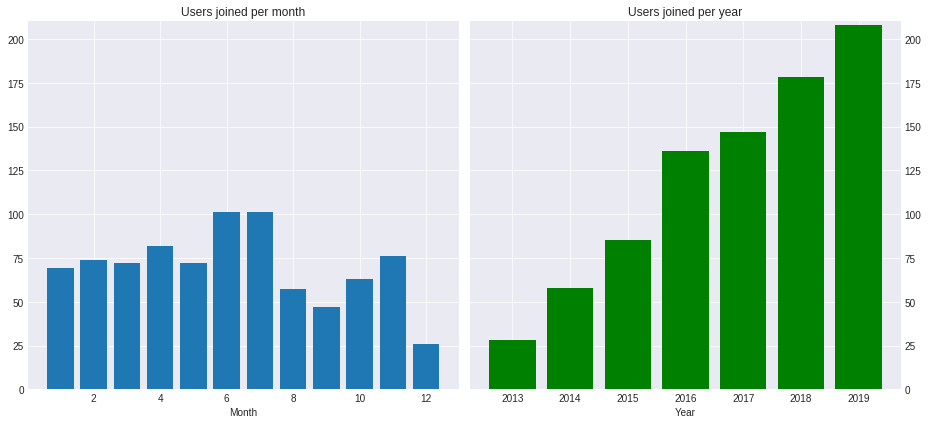

In [12]:
fig, (month_axis, year_axis) = plt.subplots(nrows=1, ncols=2, figsize=FIG_SIZE)
month_axis.bar(
    x=months,
    height=month_count
)
month_axis.set_title("Users joined per month")
month_axis.set_xlabel("Month")
month_axis.set_ylim(ymax = y_max)

year_axis.bar(
    x=years,
    height=year_count,
    color = 'g'
)
year_axis.set_title("Users joined per year")
year_axis.set_xlabel("Year")
year_axis.set_ylim(ymax = y_max)
year_axis.yaxis.tick_right()

plt.style.use('seaborn-darkgrid')
fig.tight_layout()

#### Summer months are the most popular for people to join and the group seems to be growing linearly. How does this behave over the full existence of the group?

Create a grouping variable

In [13]:
user_df['joined_month_year'] = (
    user_df['joined']
    .apply(lambda t: str(t.month) + "-" + str(t.year))
)

In [14]:
month_year_count = user_df.groupby(['joined_year', 'joined_month'])['joined_month'].count().tolist()
month_year_df = (
    user_df[['joined_year','joined_month', 'joined_month_year']]
    .drop_duplicates()
    .sort_values(['joined_year','joined_month'])
)
month_year_df.head()

,joined_year,joined_month,joined_month_year
55,2013,10,10-2013
18,2013,11,11-2013
725,2013,12,12-2013
21,2014,1,1-2014
20,2014,2,2-2014


The next cell assigns a colour to each year

In [15]:
color_map = cm.get_cmap('tab10')
color_list = [color_map(i/7.0) for i in range(0,7)]

month_year_df['color'] = (
    month_year_df['joined_year']
    .apply(lambda y: color_list[y%2013])
)
month_year_color = month_year_df['color'].tolist()

In [16]:
# Color patches allow for custom legends
color_patch_list = [mpatches.Patch(color=c, label=y) for c,y in zip(color_list, years)]

Exploring some population growth

In [18]:
cumulative_members = np.cumsum(month_year_count)

init_pop = cumulative_members[0]
rog = np.mean([new_count/total for new_count, total in zip(month_year_count, cumulative_members)])
e = math.e

malthusian_growth = [init_pop*math.pow(e, rog*time) for time in range(len(month_year_color))]

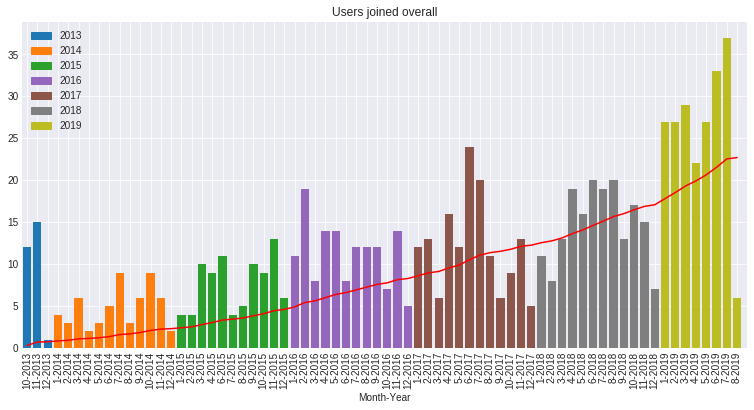

In [21]:
fig, ax = plt.subplots(figsize=FIG_SIZE)
ax.bar(
    x = month_year_df['joined_month_year'],
    height = month_year_count,
    color = month_year_color
)
ax.set_title("Users joined overall")
ax.set_xlabel("Month-Year")
ax.legend(handles=color_patch_list, loc='upper left', fancybox=True)

ax.plot(
    cumulative_members/max(month_year_count), 
    c='r'
)
ax.set_xlim(xmin=-0.5, xmax=len(month_year_df['joined_month_year']))

plt.xticks(month_year_df['joined_month_year'], rotation=90)
plt.style.use('seaborn-darkgrid')
plt.show()

It seems that the group presents some form of exponential (malthusian) growth, pretty cool!
Here's how large the group would be if it presented uniform growth rate:

In [22]:
print(f'Growth rate {rog*100:0.2f}%')

Growth rate 6.96%


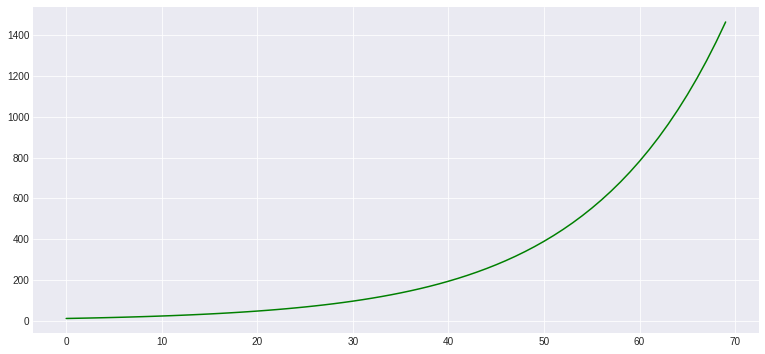

In [23]:
fig, ax = plt.subplots(figsize = FIG_SIZE)
ax.plot(malthusian_growth, c='g')
plt.style.use('seaborn-darkgrid')
plt.show()

## Some profiling of the group

In [28]:
user_df['status'].unique().tolist()

['active']

# Other things to explore:

In [155]:
def top_n_barplot(df, col, n=15, rot=45):
    data = df[col].value_counts()[:n]
    fig, ax = plt.subplots(figsize=FIG_SIZE)
    x = data.index.tolist()
    
    ax.bar(x=x, height=data)
    ax.set_xlim(xmin=-0.5, xmax=len(x))

    bar_list = ax.patches
    for bar, label in zip(bar_list, data):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height, label,
                ha='center', va='bottom')

    plt.xticks(rotation=rot)
    plt.show()

In [52]:
string_cols = [idx for c, idx in zip(user_df.dtypes, user_df.dtypes.index) if c=='object']

In [53]:
string_cols

['bio',
 'city',
 'country',
 'hometown',
 'link',
 'name',
 'state',
 'status',
 'topics',
 'joined_month_year']

In [58]:
user_df.describe(include='object')

,bio,city,country,hometown,link,name,state,status,topics,joined_month_year
count,91,840,840,152,840,840,43,840,615,840
unique,91,79,28,100,840,810,15,1,606,70
top,I'm a Professor in Digital Humanities,Dublin,ie,Dublin,http://www.meetup.com/members/114452352,Francesca,17,active,3833,7-2019
freq,1,713,743,39,1,3,14,840,4,37


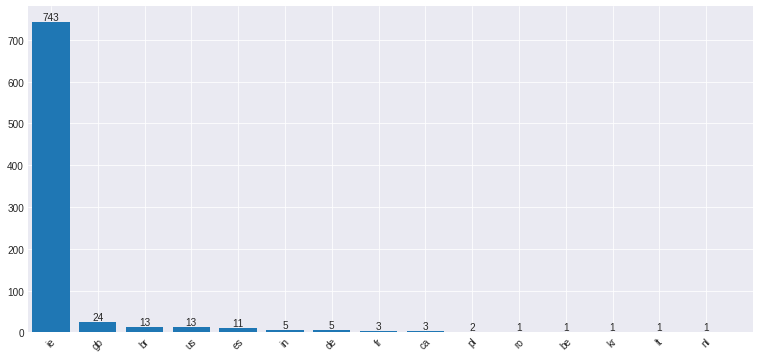

In [156]:
top_n_barplot(user_df, 'country',15)

In [157]:
user_df['hometown'] = (
    user_df['hometown']
    .str.upper()
    .str.replace(r',.+$', '')
)

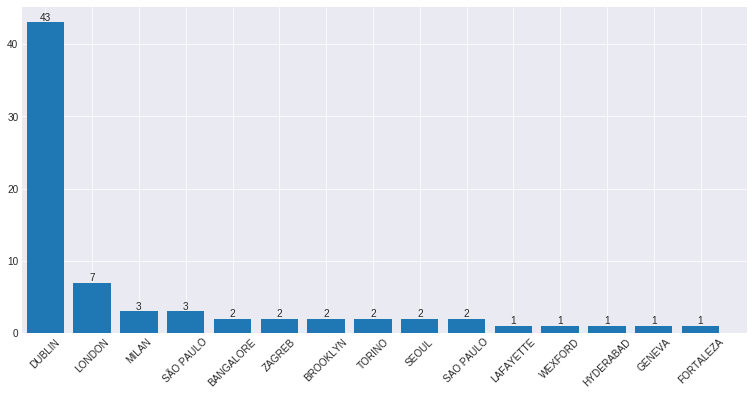

In [158]:
top_n_barplot(user_df, 'hometown')

In [159]:
user_df['first_name'] = user_df['name'].str.replace(r'(^\s+)|(\s+$)','').str.upper().str.split(' ').apply(lambda s: s[0])

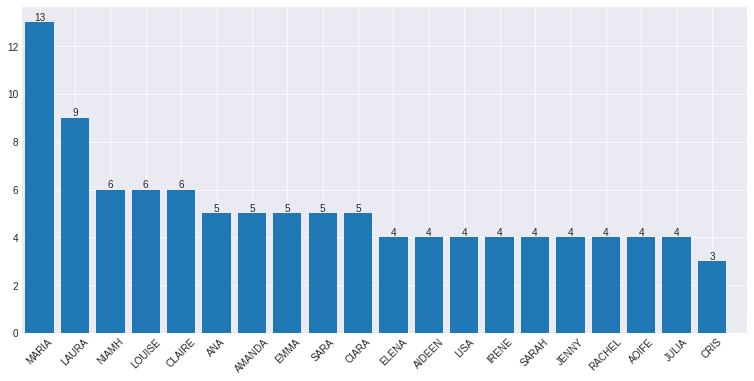

In [163]:
top_n_barplot(user_df, 'first_name', 20)